In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [3]:
def get_loss(
    activation = 'linear',
    use_bias = 1,
    target_depth = 1,
    frozen_depth = 8,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 0,
):
    test_loss = {}
    if pretrained:
        pretrained_idx = df.pretrained == 1
    else:
        # since there are many results with pretrained = NaN
        # they were run before I implemented the pretrained feature in my code
        pretrained_idx = df.pretrained != 1
        
    method = 'sgd'
    
    for tune_bias in [0,1]:
        
        if tune_bias == 0:
            tune_bias_idx = df.tune_bias == 0
        else:
            # since there are many results with tune_bias = NaN
            # they were run before I implemented the tune_bies feature in my code
            tune_bias_idx = df.tune_bias != 0
        
        run_idx = (
            (df.activation == activation) & 
            (df.method == method) & 
            (df.use_bias == use_bias) & 
            (df.target_depth == target_depth) & 
            (df.frozen_depth == frozen_depth) & 
            (df.init_mode == init_mode) & 
            (df.width == width) &
            (df.exp == exp) &
            pretrained_idx & 
            tune_bias_idx
        )

        group_df = df[run_idx].reset_index(drop = True)
        rank_set = np.unique(group_df['rank'])
        group_df_rank = {}
        test_loss[tune_bias] = {}

        for rank in rank_set:
            group_df_rank[rank] = group_df[group_df['rank'] == rank]
            min_loss_index = group_df_rank[rank]['val_loss'].idxmin()
            row_with_min_loss = group_df_rank[rank].loc[min_loss_index]
            num_params = 2*rank*width*frozen_depth + tune_bias*(width*frozen_depth)
            test_loss[tune_bias][num_params] = row_with_min_loss['test_loss']
       
        
    return pd.DataFrame(test_loss)

## FNN Approximation

In [4]:
activation = 'relu'
width = 16
exp = 'fnn'
init_mode = 'default'
target_depth = 1
frozen_depth = 2
fnn_results = {}

for pretrained in [0,1]:
    fnn_results[pretrained] = get_loss(
        activation = activation,
        target_depth = target_depth,
        frozen_depth = frozen_depth,
        init_mode = init_mode,
        width = width,
        exp = exp,
        pretrained = pretrained,
    )
    

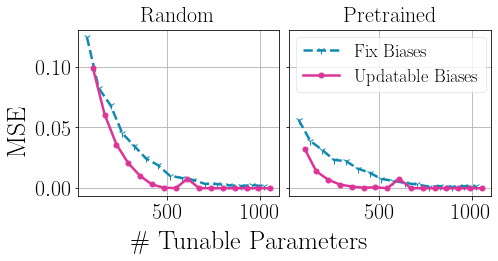

In [7]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend


sgd_marker, sgd_color, sgd_lt, sgd_ms = '1', '#118AB2', '--', 8
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for pretrained in [0,1]:
    fnn_results[pretrained][0].plot(ax = ax[pretrained], color = sgd_color, label = 'Fix Biases', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
    fnn_results[pretrained][1].plot(ax = ax[pretrained], color = our_color, label = 'Updatable Biases', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
    ax[pretrained].grid(True)

ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

# ax[0].set_ylim(0,0.15)
ax[1].legend(fontsize=18, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('\# Tunable Parameters', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/lora_bitfit_approx.pdf')
# Show the plot
plt.show()
